In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


Defining Image Properties
- To equilize the size of all the Datapoints(images)

In [2]:
Image_Width = 128
Image_Height = 128
Image_Size = (Image_Width, Image_Height)
Image_Channels = 3  # RGB

In [3]:
filenames = os.listdir(r"D:\PROGRAMMING\Programming_Python\Devtown\Deep Learning\CNN\dogs_vs_cats\train")

categories = []
for f_name in filenames:
    category = f_name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [4]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.100.jpg,0
3,cat.1000.jpg,0
4,cat.10002.jpg,0


In [5]:
df.tail()

,filename,category
19995,dog.9994.jpg,1
19996,dog.9996.jpg,1
19997,dog.9997.jpg,1
19998,dog.9998.jpg,1
19999,dog.9999.jpg,1


In [6]:
df['category'].value_counts()

category
0    10000
1    10000
Name: count, dtype: int64

**CNN -> Create a Neural Net Model**
- Conv2D: Adds convolution layers to extract spatial features from images.
- MaxPool2D: Reduces spatial dimensions (height and width) by taking the maximum value in each pool region.
- Dropout: Prevents overfitting by randomly disabling neurons during training.
- Flatten: Converts the 2D matrix of features into a 1D vector before feeding it to dense layers.
- Dense: Fully connected layer where each neuron receives input from all neurons in the previous layer.
- Activation: Applies an activation function (e.g., ReLU, softmax) to introduce non-linearity.
- BatchNormalization: Normalizes activations to stabilize and speed up training.

In [7]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 10


In [8]:
# Define data augmentation and normalization
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [9]:
train_dir = r"D:/PROGRAMMING/Programming_Python/Devtown/Deep Learning/CNN/dogs_vs_cats/train/"
test_dir = r"D:/PROGRAMMING/Programming_Python/Devtown/Deep Learning/CNN/dogs_vs_cats/test/"

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    directory=train_dir,
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

test_df = pd.DataFrame({
    "filename": os.listdir(test_dir)
})

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,
    target_size=Image_Size,
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)


Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
Found 2499 validated image filenames.


In [10]:
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(Image_Width, Image_Height, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


c:\Users\Vipul\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=1e-5
)

callbacks = [earlystop, learning_rate_reduction]


Fully Connected Block

Analyzing the model

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,942,786 (49.37 MB)

 Trainable params: 12,941,314 (49.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

Lerning Rate

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience= 10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2 ,verbose=1,factor=0.5,min_lr= 0.00001)
callbacks = [earlystop,learning_rate_reduction]

MAnanging the Data

Data Generator

In [14]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=callbacks
)


c:\Users\Vipul\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 730s 455ms/step - accuracy: 0.5806 - loss: 0.9851 - val_accuracy: 0.6712 - val_loss: 0.6135 - learning_rate: 0.0010
Epoch 2/5


c:\Users\Vipul\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


1600/1600 ━━━━━━━━━━━━━━━━━━━━ 671s 419ms/step - accuracy: 0.6652 - loss: 0.6280 - val_accuracy: 0.5773 - val_loss: 0.8309 - learning_rate: 0.0010
Epoch 3/5
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 668s 418ms/step - accuracy: 0.6937 - loss: 0.5956 - val_accuracy: 0.7628 - val_loss: 0.5353 - learning_rate: 0.0010
Epoch 4/5
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 666s 416ms/step - accuracy: 0.7248 - loss: 0.5526 - val_accuracy: 0.7423 - val_loss: 0.5280 - learning_rate: 0.0010
Epoch 5/5
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 669s 418ms/step - accuracy: 0.7456 - loss: 0.5330 - val_accuracy: 0.7048 - val_loss: 0.7420 - learning_rate: 0.0010


Save the model:

In [15]:
model.save("model1_catsVSdogs_10epoch.h5")

In [17]:
test_filenames = os.listdir(r"D:\PROGRAMMING\Programming_Python\Devtown\Deep Learning\CNN\dogs_vs_cats\test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [20]:
predict = model.predict(test_generator, steps=int(np.ceil(nb_samples / batch_size)))


250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 131ms/step


In [61]:
# Convert probabilities to class index
test_df['predicted_class_index'] = np.argmax(predict, axis=-1)

# Map class indices to labels using the reverse label_map
label_map = dict((v, k) for k, v in train_generator.class_indices.items())
test_df['predicted_label'] = test_df['predicted_class_index'].replace(label_map)


In [62]:
test_df

,filename,category,predicted_class_index,predicted_label
0,cat.10.jpg,1,1,dog
1,cat.10000.jpg,0,0,cat
2,cat.10001.jpg,0,0,cat
3,cat.10007.jpg,1,1,dog
4,cat.10017.jpg,0,0,cat
...,...,...,...,...
2494,cat.9968.jpg,0,0,cat
2495,cat.9980.jpg,0,0,cat
2496,cat.9983.jpg,1,1,dog
2497,cat.9989.jpg,0,0,cat


In [37]:
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

C:\Users\Vipul\AppData\Local\Temp\ipykernel_20732\3639850117.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })


In [48]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,942,788 (49.37 MB)

 Trainable params: 12,941,314 (49.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

 Optimizer params: 2 (12.00 B)

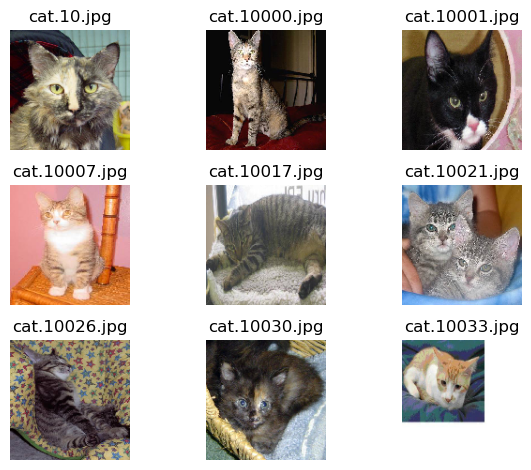

In [34]:
from keras.utils import load_img
import matplotlib.pyplot as plt

Image_Size = (128, 128)

for i in range(9):
    img_path = os.path.join(test_path, df.loc[i, 'filename'])
    img = load_img(img_path, target_size=Image_Size)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(df.loc[i, 'filename'])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [63]:
print(test_df[['filename', 'predicted_label']].head(10))  # Show first 10 predictions

        filename predicted_label
0     cat.10.jpg             dog
1  cat.10000.jpg             cat
2  cat.10001.jpg             cat
3  cat.10007.jpg             dog
4  cat.10017.jpg             cat
5  cat.10021.jpg             dog
6  cat.10026.jpg             dog
7  cat.10030.jpg             cat
8  cat.10033.jpg             dog
9  cat.10035.jpg             cat


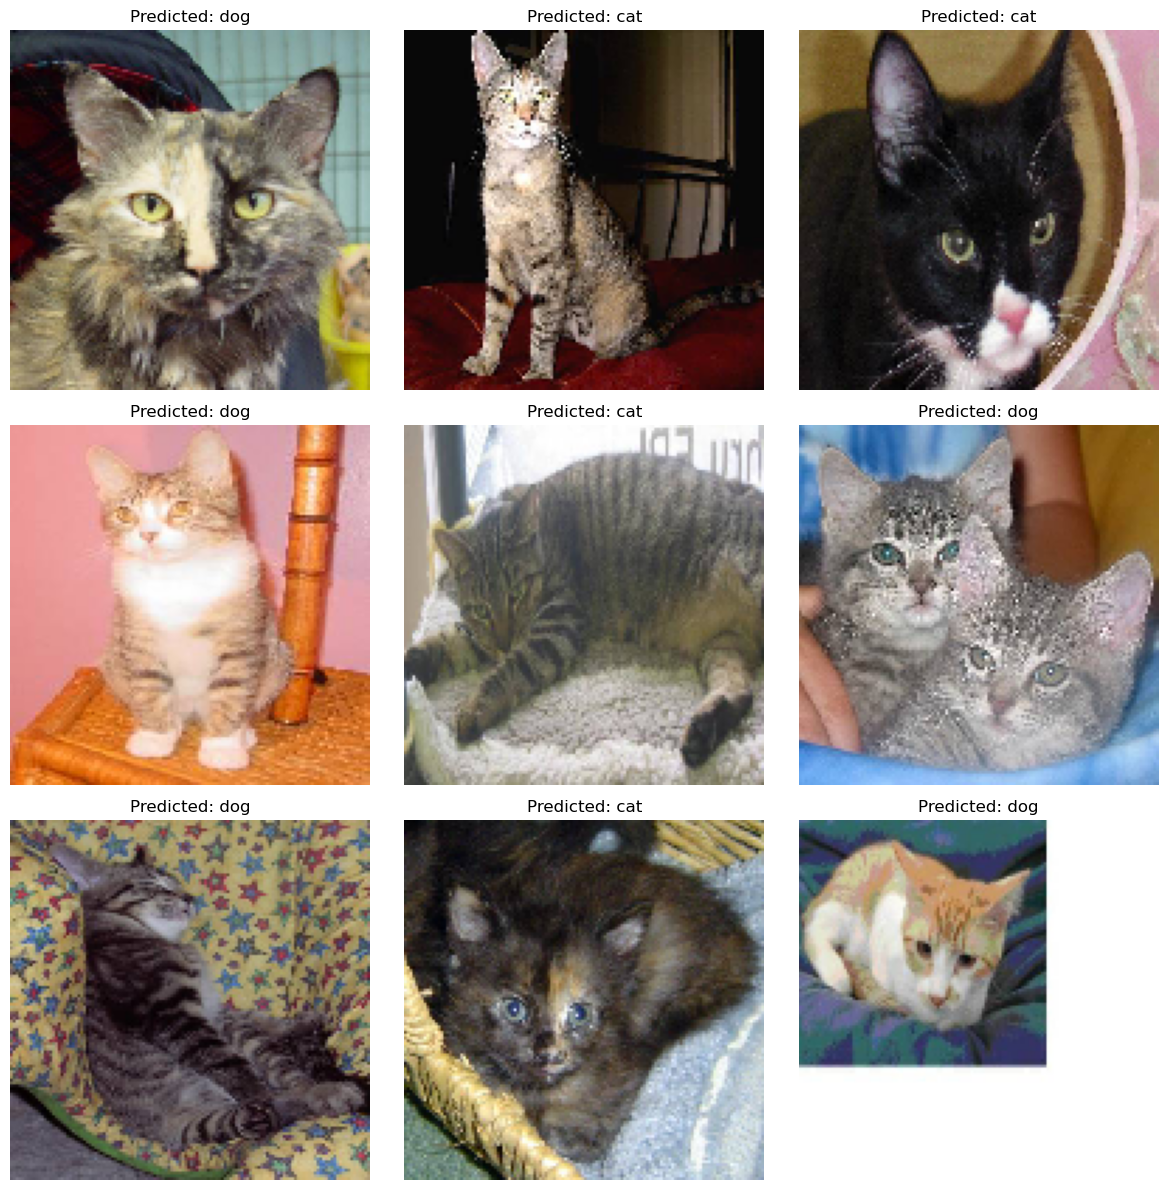

In [64]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.figure(figsize=(12, 12))
for i in range(9):
    img_path = os.path.join(test_dir, test_df.loc[i, 'filename'])
    img = load_img(img_path, target_size=Image_Size)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {test_df.loc[i, 'predicted_label']}")
    plt.axis('off')
plt.tight_layout()
plt.show()
